## Extended Trapping SINDy
By Mai Peng and Alan Kaptanoglu

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself (see the Example 8 Jupyter notebook). This is really nice but there are three potential caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for quadratically nonlinear dynamics (typically fluid and plasma flows) with energy-preserving, quadratic, nonlinearities. Moreover, we have good reason to believe that (3) generic quadratically nonlinear models will always be globally *unbounded*, so for these situations we can also promote local Lyapunov stability of the origin using some variations of the original Trapping SINDy algorithm. That is the goal of this notebook -- to illustrate how various forms of global and local stability can be promoted explicitly in the SINDy method to obtain stable data-driven models.

For the following, we will consider dynamical models of the form
$$\dot{x}_i = C_i +  L_{ij}x_j + Q_{ijk}x_ix_j.$$
For global stability promotion, we will require that the totally symmetric part of the quadratic coefficients vanishes (without loss of generality, $Q_{ijk}$ is symmetric in the last two indices):
$$ Q_{ijk} + Q_{jik} + Q_{kij} = 0.$$
This equation can be implemented as a hard or soft constraint in the optimization. For dynamical models that do not satisfy this condition, we can still promote locally stable models that are stable even at very large distances of the origin. The following examples show different ways to relax this hard constraint.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pysindy as ps 
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import useful functions
from trapping_utils import *

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

### Check global stability of the Lorenz model
The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic tensor has zero totally symmetric part, this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary for models that do not quite satisfy the constraint on $Q_{jik}$, but in this case is not sufficient for global boundedness.

A decent-enough algorithm for a nonlinear search for such a $\mathbf{m}$ that makes $A^S_{ij}$ negative definite is simulated annealing, and a simple interface is provided by scipy. 

In [2]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 2000
eta = 1.0e5
constraint_zeros, constraint_matrix = make_constraints(r)

alpha_m = 2e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t, quiet=True)
model.print()

# Extract model coefficients and check how well constraint is satisfied
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_unsym_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
print('Maximum deviation of Qijk from having zero totally symmetric part: ',
      np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.500e+02 ... 1.273e-03 ... 0.00e+00 ... 4.93e-21 ... 9.36e-48 ... 2.50e+02
  200 ... 2.500e+02 ... 3.776e-06 ... 0.00e+00 ... 4.93e-21 ... 6.49e-47 ... 2.50e+02
  400 ... 2.500e+02 ... 5.994e-07 ... 0.00e+00 ... 4.93e-21 ... 2.96e-47 ... 2.50e+02
  600 ... 2.500e+02 ... 2.268e-07 ... 0.00e+00 ... 4.93e-21 ... 1.65e-47 ... 2.50e+02
  800 ... 2.500e+02 ... 1.189e-07 ... 0.00e+00 ... 4.93e-21 ... 5.27e-47 ... 2.50e+02
 1000 ... 2.500e+02 ... 7.381e-08 ... 0.00e+00 ... 4.93e-21 ... 1.37e-47 ... 2.50e+02
 1200 ... 2.500e+02 ... 5.075e-08 ... 0.00e+00 ... 4.93e-21 ... 5.15e-47 ... 2.50e+02
 1400 ... 2.500e+02 ... 3.736e-08 ... 0.00e+00 ... 4.93e-21 ... 3.01e-47 ... 2.50e+02
 1600 ... 2.500e+02 ... 2.889e-08 ... 0.00e+00 ... 4.93e-21 ... 5.71e-48 ... 2.50e+02
 1800 ... 2.500e+02 ... 2.318e-08 ... 0.00e+00 ... 4.93e-21 ... 1.83e-47 ... 2.50e+02
(x0)' = 0.060 1 + -9.868 x0 + 9.938 x1 + -0.009 x2 

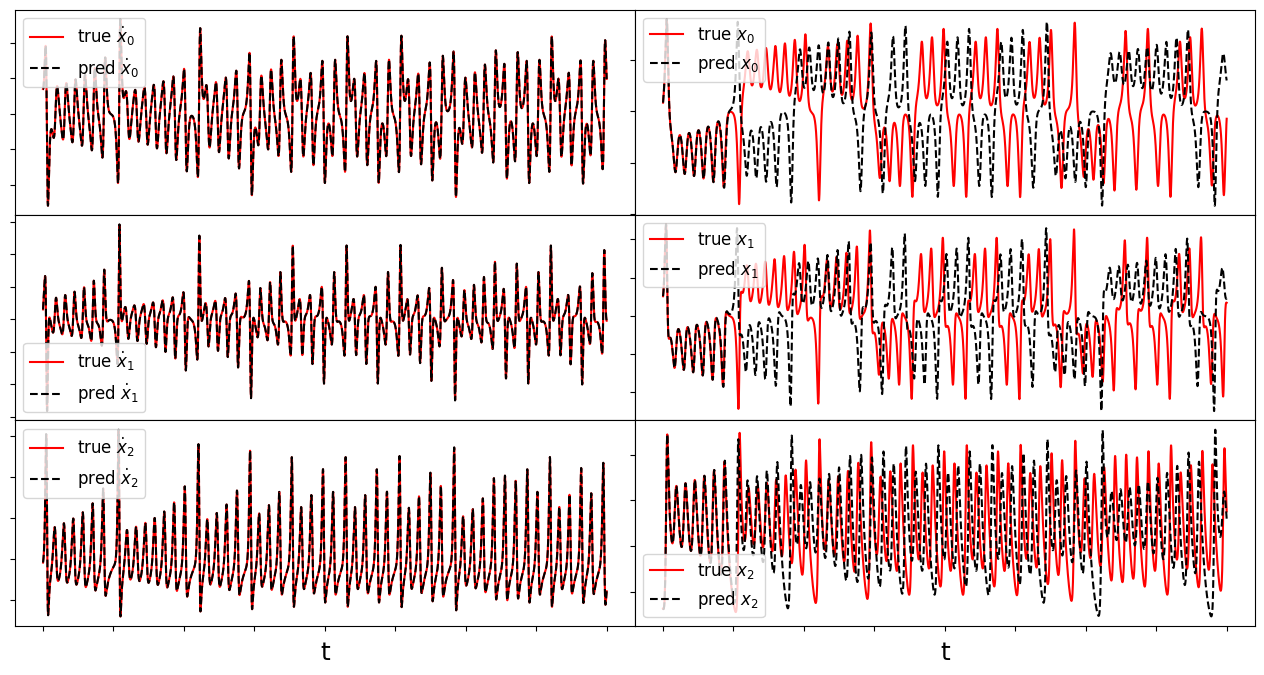

Frobenius error =  0.732994370668256
optimal m:  [-1.13710087 -0.12418868 36.74842101]
As eigvals:  [-10.01091832  -2.66322095  -0.93814258]
Estimate of trapping region size, Rm =  105.175701414106
Normalized trapping region size, Reff =  4.43861651794581
Local stability size, R_ls=  13737785854236.9
Frobenius coefficient error =  1.502387409872766
Time-averaged derivative error =  1.2124170558808809e-05


In [3]:
# Calculate the x_dot and x trajectories for train and test sets
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

### Use simulated annealing 
We are going to check if any $\mathbf{m}$ exists such that $\mathbf{A}^S$ is negative definite, using the identified coefficients, to verify again that our model is globally stable.

In [4]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

boundvals = np.zeros((r, 2))
boundmax = 1000
boundmin = -1000
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

PL_tensor_unsym = sindy_opt.PL_unsym_
PL_tensor = sindy_opt.PL_
PM_tensor = sindy_opt.PM_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PM_tensor, Xi, axes=([4, 3], [0, 1]))

# run simulated annealing 
algo_sol = anneal_algo(obj_function, bounds=boundvals,  # obj_function imported from utils.py
                       args=(L, Q, np.eye(r)), 
                       maxiter=500)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

Result:
Optimal m =  [ 1.00000000e+03 -7.79000388e-01  1.87670720e+01]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -2.106897251457853 



### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A^S)  \quad s.t. \quad Q_{ijk} + Q_{jik} + Q_{kji} = 0.$$
This problem is solved with a convex relaxation of the optimization. 

Below, we relax the hard constraint to a soft constraint and instead solve 
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A^S)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allows us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. A conservative estimate of the local stability is:
$$\rho_+ = \frac{3}{2r^{\frac{3}{2}}\epsilon_Q} \left( \sqrt{\lambda^2_1(\textbf{A}^S) - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3}\|\mathbf{d}\|_2} - \lambda_1(\textbf{A}^S) \right).$$
And a conservative radius of the trapping region is given by:
$$\rho_- = -\frac{3}{2r^{\frac{3}{2}}\epsilon_Q} \left( \sqrt{\lambda^2_1(\textbf{A}^S) - \frac{4r^{\frac{3}{2}}\epsilon_Q}{3}\|\mathbf{d}\|_2} + \lambda_1(\textbf{A}^S) \right).$$

In other words, there is a region $\rho_- < \|\mathbf{a}(t)\| < \rho_+$ such that the energy $K$ satisfies $K > 0$ and $\dot{K} < 0$, so that any trajectory with initial condition $\|\mathbf{a}_0\| < \rho_+$ will be bounded for all time. This is because it will fall towards the origin until at least it reaches $\rho_-$, and then it stays in the ball of radius $\rho_-$ for all time.

### A better way to optimize
However, we find empirically that CVXPY struggles to solve the inequality-constrained problem adequately, and find much better performance by incorporating the constraint as a loss term in the objective.
Two other loss terms that can be used as alternatives to increase the size of the stability radius while avoiding extra constraints:
$$\alpha^{-1}\|Q_{ijk}\|$$
and
$$\beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We can combine all of these options into the following unconstrained optimization problem:
$$argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta^{-1} \lambda_1(\mathbf A) + \alpha^{-1}\|Q_{ijk}\| + \beta^{-1}\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\alpha \gg \beta$, $\alpha \ll \beta$, and $\alpha \sim \beta \sim 1.$

### First case: $\alpha \gg 1$, $\beta \ll 1$, for which the model should just zero out all the quadratic nonlinear terms

In [5]:
max_iter = 500
eta = 1.0e2
alpha = 1e-20
beta = 1e20
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.574e+07 ... 5.290e-01 ... 0.00e+00 ... 1.40e-05 ... 1.51e-45 ... 1.57e+07
(x0)' = 0.003 1 + -9.978 x0 + 9.978 x1
(x1)' = 4.143 1 + -13.214 x0 + 10.034 x1 + 0.172 x2
(x2)' = -0.280 1 + -0.452 x0 + 0.728 x1 + -0.017 x2
optimal m:  [-1.16595599 -0.55935101 -1.99977125]
As eigvals:  [-10.11120965  -0.03433847  10.18579756]
Estimate of trapping region size, Rm =  1.4610062676797513
Normalized trapping region size, Reff =  0.06165726936313025


Indeed, we found that if $\alpha \gg 1$ large enough, the quadratic terms in the model are zeroed, which is bad news both for fitting the model and for applying the trapping theorem since the theorem relies on nontrivial quadratic contributions. 

### Second case: $\alpha \ll 1$, $\beta \gg 1$, which should reproduce the energy-preserving nonlinear constraint to high accuracy 
This is a different strategy for stability -- don't make the model's quadratic nonlinearities weak, but make it so that the totally symmetric part of $Q_{ijk}$ is very small.

In [16]:
max_iter = 2000
eta = 1.0e5
alpha = 1e10
beta = 15e-8
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.278e+02 ... 1.270e-03 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
  200 ... 2.278e+02 ... 2.674e-05 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
  400 ... 2.278e+02 ... 3.717e-06 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
  600 ... 2.278e+02 ... 1.229e-06 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
  800 ... 2.278e+02 ... 5.894e-07 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
 1000 ... 2.278e+02 ... 3.434e-07 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
 1200 ... 2.278e+02 ... 2.250e-07 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
 1400 ... 2.278e+02 ... 1.594e-07 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
 1600 ... 2.278e+02 ... 1.193e-07 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
 1800 ... 2.278e+02 ... 9.311e-08 ... 0.00e+00 ... 4.93e-11 ... 9.02e+00 ... 2.37e+02
(x0)' = 0.044 1 + -9.903 x0 + 9.953 x1 + -0.007 x2 

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:882: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


### Plot how the two stability radii changes as the algorithm iterates
As the algorithm iterates, it is biasing the model to have a negative definite $\mathbf{A}^S$ matrix. Once this is true, we can estimate the local Lyapunov stability radius $\rho_+$ and the trapping region radius $\rho_-$.

#### Note that with the soft constraint we can get the stability radius arbitrarily large here!

Maximum deviation from having zero totally symmetric part:  0.001134189504885448


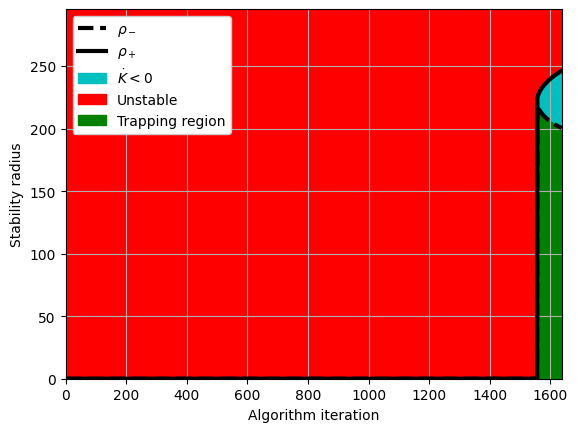

In [7]:
rhos_minus, rhos_plus = make_trap_progress_plots(r, sindy_opt)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Maximum deviation from having zero totally symmetric part: ',
      np.max(np.abs(Q_sum)))

### Plot the region where $\dot K \ge 0$ in the trapping region and the projection of whose contour on 2d planes

In [8]:
def kdot(X, Y, Z, sindy_opt, mod_matrix = None):
    PQ_tensor = sindy_opt.PQ_
    PM_tensor = sindy_opt.PM_
    PC_tensor = sindy_opt.PC_
    opt_m = sindy_opt.m_history_[-1]
    mPM = np.tensordot(PM_tensor, opt_m, axes=([2], [0]))
    P_tensor = PL_tensor + mPM
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    C = np.tensordot(PC_tensor, Xi, axes=([2, 1], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = C + np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    N = X.shape[0]
    vdot = np.zeros(X.shape)
    if mod_matrix is None:
        mod_matrix = np.eye(d.shape[0])
    d = mod_matrix @ d
    Q = mod_matrix @ Q
    As = mod_matrix @ As
    for i in range(N):
        for j in range(N):
            for k in range(N):
                y = np.array([X[i, j, k], Y[i, j, k], Z[i, j, k]])
                vdot[i, j, k] = d.T @ y + y.T @ As @ y + y.T @ (Q @ y) @ y

    return vdot

x = np.linspace(-50, 50, 201)
y = np.linspace(-50, 50, 201)
z = np.linspace(-50, 50, 201)
X, Y, Z = np.meshgrid(x, y, z)
F = kdot(X, Y, Z, sindy_opt)

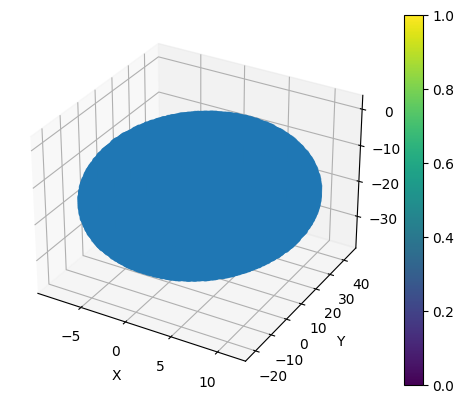

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the isosurface
mask = F > 0
Xmask = X[mask]
Ymask = Y[mask]
Zmask = Z[mask]
img = ax.scatter3D(Xmask, Ymask, Zmask, cmap=cm.coolwarm)
fig.colorbar(img)
# Set the axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

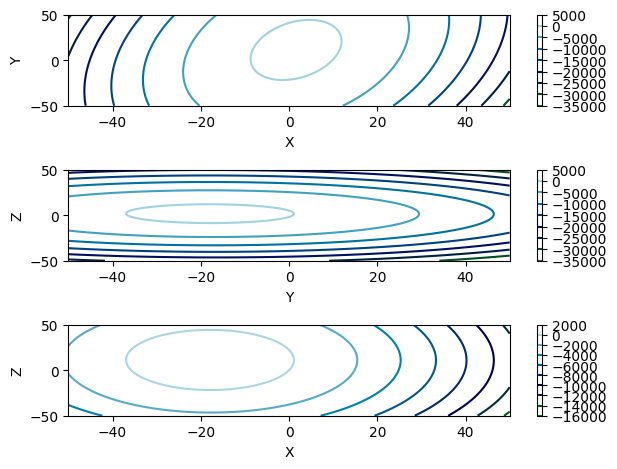

In [10]:
dim_ = X.shape[0]
X_, Y_ = np.meshgrid(x, y)
F_xy = np.zeros((F.shape[0], F.shape[1]))
F_yz = np.zeros((F.shape[0], F.shape[1]))
F_xz = np.zeros((F.shape[0], F.shape[1]))
for i in range(dim_):
    for j in range(dim_):
        F_xy[i, j] = np.max(F[i, j, :])
        F_yz[i, j] = np.max(F[:, i, j])
        F_xz[i, j] = np.max(F[i, :, j])

fig, axes = plt.subplots(nrows=3, ncols=1)

fig1 = axes[0].contour(X_, Y_, F_xy, cmap = 'ocean')
fig2 = axes[1].contour(X_, Y_, F_yz, cmap = 'ocean')
fig3 = axes[2].contour(X_, Y_, F_xz, cmap = 'ocean')
fig.colorbar(fig1)
fig.colorbar(fig2)
fig.colorbar(fig3)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[1].set_xlabel('Y')
axes[1].set_ylabel('Z')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Z')
plt.tight_layout()
plt.show()

### Repeat $\alpha \gg 1$, $\beta \ll 1$ case with $\lambda > 0$
I find that solver will fail if eps_solver parameter is made too small (error tolerance of the CVXPY solver is very stringent)

In [11]:
max_iter = 100
eta = 1.0e2
alpha = 1e20
beta = 1e-20
threshold = 5
alpha_m = 9e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    gamma=-1,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    eps_solver=1e-3
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print('Maximum deviation from having zero totally symmetric part: ',
      np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))
# make_progress_plots(r, sindy_opt)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.500e+02 ... 1.273e+00 ... 2.68e+02 ... 4.93e-21 ... 1.00e+07 ... 1.00e+07
   10 ... 2.501e+02 ... 1.426e-01 ... 2.68e+02 ... 4.93e-21 ... 1.66e+07 ... 1.66e+07
   20 ... 2.502e+02 ... 3.443e-02 ... 2.68e+02 ... 4.93e-21 ... 1.21e+07 ... 1.21e+07
   30 ... 2.502e+02 ... 1.223e-02 ... 2.68e+02 ... 4.93e-21 ... 1.50e+07 ... 1.50e+07
   40 ... 2.504e+02 ... 5.694e-03 ... 2.68e+02 ... 4.93e-21 ... 1.05e+06 ... 1.05e+06
   50 ... 2.504e+02 ... 3.160e-03 ... 2.68e+02 ... 4.93e-21 ... 2.41e+06 ... 2.41e+06
   60 ... 2.505e+02 ... 1.971e-03 ... 2.68e+02 ... 4.93e-21 ... 4.97e+06 ... 4.97e+06
   70 ... 2.505e+02 ... 1.334e-03 ... 2.68e+02 ... 4.93e-21 ... 5.47e+06 ... 5.47e+06
   80 ... 2.505e+02 ... 9.576e-04 ... 2.68e+02 ... 4.93e-21 ... 4.92e+06 ... 4.92e+06
   90 ... 2.505e+02 ... 7.188e-04 ... 2.68e+02 ... 4.92e-21 ... 3.89e+06 ... 3.89e+06
(x0)' = 0.056 1 + -9.846 x0 + 9.923 x1 + -0.009 x2 

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:882: ConvergenceWarning: TrappingSR3._reduce did not converge after 100 iters.
  warnings.warn(


Maximum deviation from having zero totally symmetric part:  1.21346268077384e-07


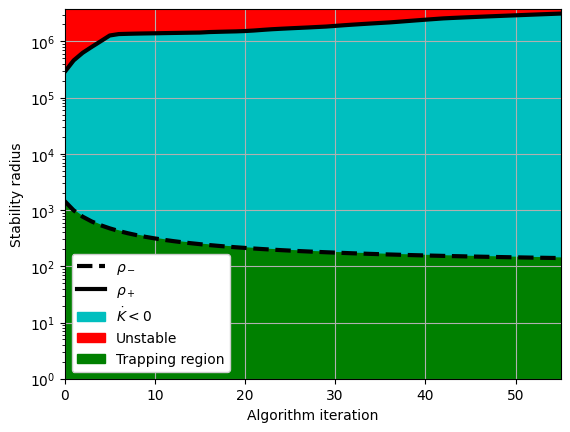

In [12]:
rhos_minus, rhos_plus = make_trap_progress_plots(r, sindy_opt)
plt.yscale('log')
plt.ylim(1, rhos_plus[-1] * 1.2)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Maximum deviation from having zero totally symmetric part: ',
      np.max(np.abs(Q_sum)))

### Now we add some noise to the Lorenz data and see if trapping extended algorithm improves robustness to noise.

In [28]:
lorenz_noise = np.random.normal(0, 4, x_train.shape) # change the std
x_train_noise = lorenz_noise + x_train

max_iter = 5000
eta = 1.0e5
alpha = 1e10
beta = 15e-8
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train_noise, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.769e+08 ... 1.050e-03 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
  500 ... 1.769e+08 ... 6.652e-06 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 1000 ... 1.769e+08 ... 1.649e-06 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 1500 ... 1.769e+08 ... 7.771e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 2000 ... 1.769e+08 ... 4.661e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 2500 ... 1.769e+08 ... 3.181e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 3000 ... 1.769e+08 ... 2.357e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 3500 ... 1.769e+08 ... 1.850e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 4000 ... 1.769e+08 ... 1.515e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
 4500 ... 1.769e+08 ... 1.282e-07 ... 0.00e+00 ... 1.87e-11 ... 4.77e+04 ... 1.77e+08
(x0)' = 12.619 1 + 0.484 x0 + 4.504 x1 + -1.130 x2 

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:882: ConvergenceWarning: TrappingSR3._reduce did not converge after 5000 iters.
  warnings.warn(


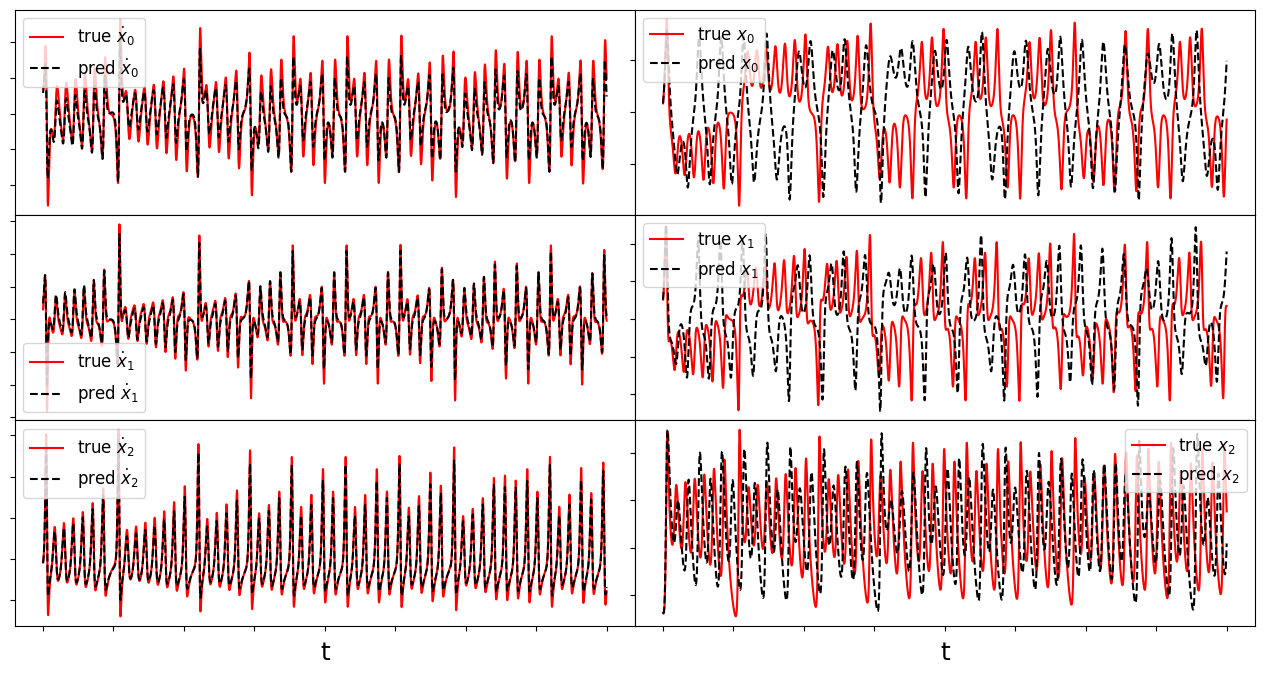

Frobenius error =  0.7563193520311914
optimal m:  [-3.83018781 -6.42910968 41.89243899]
As eigvals:  [-8.63169282 -1.80263206 -0.85071489]
Estimate of trapping region size, Rm =  0
Normalized trapping region size, Reff =  0.0
Local stability size, R_ls=  0
Frobenius coefficient error =  1.0963056357243475
Time-averaged derivative error =  0.04090799587122476


In [29]:
# Calculate the x_dot and x trajectories for train and test sets
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

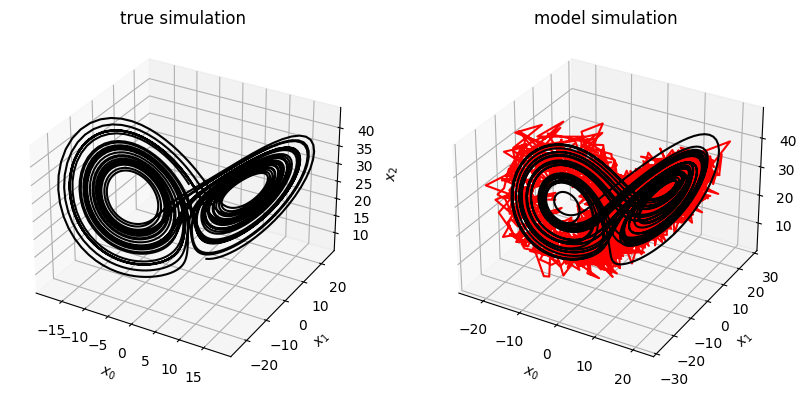

In [30]:
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_train_noise[:, 0], x_train_noise[:, 1], x_train_noise[:, 2], 'r-')
ax2.plot(x_train_pred[:, 0], x_train_pred[:, 1], x_train_pred[:, 2], 'k-')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()